In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import sklearn.metrics as metrics

import matplotlib.pyplot as plt


In [2]:
BATCH_SIZE = 32


transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

5.7%

31.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


102.8%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




82.2%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [3]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Text(0.5, 1.0, 'Label : 5')

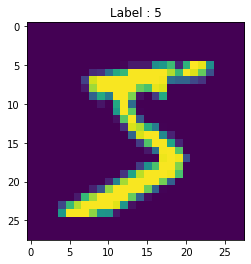

In [4]:
plt.figure()
x, y = trainset[0]
plt.imshow(x[0])
plt.title(f'Label : {y}')

In [31]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x = x.flatten(start_dim=1)
        
        x = self.d1(x)
        x = F.relu(x)
        
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)

        return out
    

In [47]:
lr = 0.001
num_epoch = 5
model = MyModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epoch):
    running_loss = .0
    train_acc = .0
    for i, (X, y) in enumerate(trainloader):
        logits = model(X)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        running_loss += loss.detach().item()
        
        pred_class = torch.argmax(logits, 1).flatten()
        train_acc += (pred_class == y).type(torch.float).mean().item()
    
    print(f"Epoch: {epoch} | Loss: {running_loss/i:.4f} | Train Accuracy: {train_acc/i:.2f}")
        

Epoch: 0 | Loss: 1.6417 | Train Accuracy: 0.82
Epoch: 1 | Loss: 1.5585 | Train Accuracy: 0.90
Epoch: 2 | Loss: 1.4847 | Train Accuracy: 0.98
Epoch: 3 | Loss: 1.4780 | Train Accuracy: 0.99
Epoch: 4 | Loss: 1.4742 | Train Accuracy: 0.99


In [41]:
torch.argmax(out, 1) == y

tensor([False,  True, False, False, False, False, False, False,  True, False,
        False, False,  True, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False])

In [42]:
y.shape

torch.Size([32])

In [4]:
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T
from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [5]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task="node"):
        self.task = task
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))
        
        # post message passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(0.25),
            nn.Linear(hidden_dim, output_dim))
        
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        if self.task == "node":
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            ))
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
            x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x  # later visualize
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if i != self.num_layers - 1:
                x = self.lns[i](x)
            
        if self.task == "graph":
            x = pyg_nn.global_mean_pool(x, batch)
        
        x = self.post_mp(x)
        
        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [11]:
def train(dataset, task, writer):
    if task == "graph":
        data_size = len(dataset)
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
    else:
        test_loader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    # build model
    model = GNNStack(input_dim=max(dataset.num_node_features, 1), 
                     hidden_dim=32, 
                     output_dim=dataset.num_classes, task=task)
    opt = optim.Adam(model.parameters(), lr=0.01)

    # train
    for epoch in range(200):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            embedding, pred = model(batch)
            label = batch.y
            if task == "node":
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        writer.add_scaler("loss", total_loss, epoch)
        
        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, test_acc))
            writer.add_scalar("test accuracy", test_acc, epoch)
    
    return model   
    

In [12]:
def test(loader, model, is_validation=False):
    model.eval()
    
    correct = 0
    for data in loader:
        with torch.no_grad():
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        if model.task == "node":
            mask = data.val_mask if is_validation else data.test_mask
            pred = pred[mask]
            label = data.y[mask]
        
        correct += pred.eq(label).sum().item()
    
    if model.task == "graph":
        total = len(loader.dataset)
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item()
    
    return correct / total

In [17]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = TUDataset(root="/tmp/ENZYMES", name="ENZYMES")
dataset = dataset.shuffle()
task = "graph"

# model = train(dataset, task, writer)


In [18]:
data_size = len(dataset)
loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)

In [21]:
for i in range(len(dataset)):
    print(dataset[i])

Data(edge_index=[2, 184], x=[49, 3], y=[1])
Data(edge_index=[2, 146], x=[39, 3], y=[1])
Data(edge_index=[2, 78], x=[23, 3], y=[1])
Data(edge_index=[2, 90], x=[25, 3], y=[1])
Data(edge_index=[2, 102], x=[30, 3], y=[1])
Data(edge_index=[2, 58], x=[16, 3], y=[1])
Data(edge_index=[2, 136], x=[32, 3], y=[1])
Data(edge_index=[2, 118], x=[40, 3], y=[1])
Data(edge_index=[2, 66], x=[18, 3], y=[1])
Data(edge_index=[2, 116], x=[30, 3], y=[1])
Data(edge_index=[2, 110], x=[25, 3], y=[1])
Data(edge_index=[2, 80], x=[24, 3], y=[1])
Data(edge_index=[2, 72], x=[20, 3], y=[1])
Data(edge_index=[2, 74], x=[18, 3], y=[1])
Data(edge_index=[2, 102], x=[26, 3], y=[1])
Data(edge_index=[2, 124], x=[33, 3], y=[1])
Data(edge_index=[2, 122], x=[32, 3], y=[1])
Data(edge_index=[2, 190], x=[47, 3], y=[1])
Data(edge_index=[2, 60], x=[15, 3], y=[1])
Data(edge_index=[2, 190], x=[44, 3], y=[1])
Data(edge_index=[2, 106], x=[28, 3], y=[1])
Data(edge_index=[2, 116], x=[37, 3], y=[1])
Data(edge_index=[2, 154], x=[42, 3], y=[

In [36]:
dataset[0].edge_index

tensor([[ 0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,  4,  4,
          5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  8,  8,  8,  8,
          9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 13, 13, 13, 14,
         14, 14, 15, 15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18,
         19, 19, 19, 19, 20, 20, 20, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23,
         23, 23, 24, 24, 24, 24, 25, 25, 25, 25, 26, 26, 26, 26, 27, 27, 28, 28,
         28, 29, 29, 29, 30, 30, 30, 31, 31, 31, 31, 32, 32, 32, 32, 33, 33, 33,
         34, 34, 34, 35, 35, 35, 35, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 37,
         38, 38, 38, 38, 39, 39, 39, 39, 40, 40, 41, 41, 41, 41, 42, 42, 42, 43,
         43, 43, 44, 44, 44, 44, 45, 45, 45, 45, 46, 46, 46, 46, 47, 47, 47, 47,
         48, 48, 48, 48],
        [ 1, 31,  0,  2,  3, 19, 32,  1,  3, 32, 41,  1,  2, 17, 33, 33, 34, 42,
         34, 35, 43,  7, 22, 35, 36, 44, 45,  6,  8, 35, 36, 44,  7, 24, 36, 37,
  

In [29]:
dataset[0].edge_attr is None

True

In [32]:
dataset[0].pos is None

True

In [35]:
dataset[0].num_node_features

3

In [39]:
for i in loader :
    print(i.batch.shape)

torch.Size([2235])
torch.Size([1927])
torch.Size([2019])
torch.Size([2057])
torch.Size([2217])
torch.Size([1933])
torch.Size([2102])
torch.Size([1079])


In [42]:
i

Batch(edge_index=[2, 4042], x=[1079, 3], y=[32], batch=[1079], ptr=[33])

In [43]:
i.x

tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])

In [44]:
i.edge_index

tensor([[   0,    0,    0,  ..., 1078, 1078, 1078],
        [   1,    5,    6,  ..., 1062, 1076, 1077]])

In [45]:
i.keys

['ptr', 'x', 'y', 'edge_index', 'batch']

In [46]:
i.ptr

tensor([   0,   36,   50,   77,  110,  162,  204,  220,  272,  286,  310,  354,
         380,  419,  452,  496,  510,  523,  567,  592,  616,  652,  703,  742,
         769,  807,  830,  869,  918,  970, 1018, 1046, 1079])

In [73]:
dataset = Planetoid(root="/tmp/Cora", name="Cora")

In [74]:
len(dataset)

1

In [84]:
dataset

Cora()

In [85]:
dataset.num_classes

7

In [86]:
dataset.num_node_features

1433

In [87]:
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [88]:
dataset[0].train_mask.sum().item()

140

In [89]:
dataset[0].train_mask.shape

torch.Size([2708])

In [90]:
dataset[0].x.shape

torch.Size([2708, 1433])

In [91]:
dataset[1].x.shape

IndexError: range object index out of range

In [93]:
dataset[0].y.shape

torch.Size([2708])

In [96]:
node_loader = DataLoader(dataset, batch_size=32, shuffle=True)

for batch in node_loader:
    print(batch.num_graphs)
    print(batch)


1
Batch(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], batch=[2708], ptr=[2])


In [98]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader


dataset = TUDataset(root="/tmp/ENZYMES", name="ENZYMES", use_node_attr=True)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

for batch in loader:
    print(batch.num_graphs)


32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
24


In [99]:
batch

Batch(edge_index=[2, 3126], x=[797, 21], y=[24], batch=[797], ptr=[25])

In [100]:
print(batch.x[0, :], batch.y)

tensor([1.4000e+01, 2.0221e+01, 6.3670e+01, 5.0000e-02, 2.9700e+00, 1.1830e+02,
        3.0000e+00, 4.0000e+00, 7.0000e+00, 6.0000e+00, 4.0000e+00, 4.0000e+00,
        5.0000e+00, 3.0000e+00, 6.0000e+00, 2.0000e+00, 5.0000e+00, 7.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00]) tensor([0, 3, 0, 2, 4, 4, 3, 1, 3, 2, 3, 2, 0, 4, 0, 4, 4, 1, 1, 4, 0, 3, 3, 5])


In [104]:
print(batch.y.shape, batch.x.shape)


torch.Size([24]) torch.Size([797, 21])


In [105]:
batch.batch

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6, 